In [1]:
from skxray.core.accumulators.correlation import MultiTauCorrelation
import numpy as np
import time as ttime
import matplotlib.pyplot as plt
%matplotlib notebook

## First, let's demo with synthetic data.

The plot a few cells down should live update with the first value of approximately sqrt(2) and the remaining values should be essentially one

In [29]:
num_levels = 5
num_bufs = 4  # must be even
xdim = 512
ydim = 512
stack_size = 100
synthetic_data = np.random.randint(1, 10, (stack_size, xdim, ydim))

rois = np.zeros_like(synthetic_data[0])
# make sure that the ROIs can be any integers greater than 1. They do not
# have to start at 1 and be continuous
rois[0:xdim//10, 0:ydim//10] = 5
rois[xdim//10:xdim//5, ydim//10:ydim//5] = 3

correlator = MultiTauCorrelation(num_levels, num_bufs, rois)

<IPython.core.display.Javascript object>


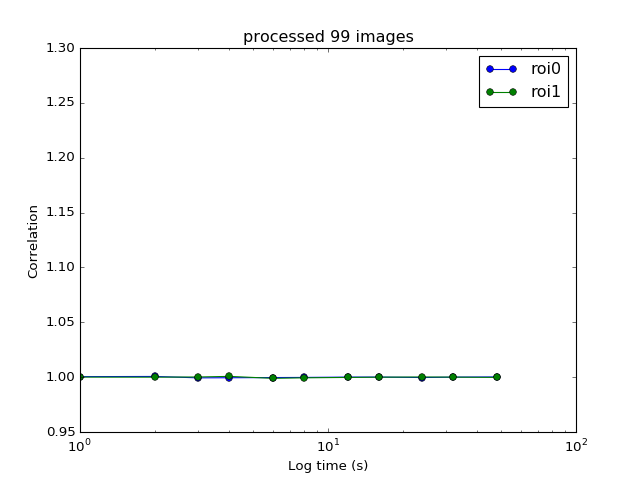

In [30]:
fig, ax = plt.subplots()


### Define a helper function to process and update the live plot

In [38]:
def update_plot(ax, g2s, lags, img_num):
    ax.cla()
    for n, g2 in enumerate(g2s.T):
        ax.plot(lags[:len(g2)], g2, '-o', label='roi%s' % n)
    ax.set_title('processed %s images' % img_num)
    ax.legend(loc=0)
    ax.set_xlabel('Log time (s)')
    ax.set_ylabel('Correlation')
    try:
        ax.set_xscale('log')
        ax.figure.canvas.draw()
    except ValueError:
        # this happens on the first few draws
        ax.set_xscale('linear')
        ax.figure.canvas.draw()
    ttime.sleep(0.001)

## Show the correlator working with synthetic data

In [39]:
correlator.reset()
for im in synthetic_data:
    correlator.process(im)
    update_plot(ax, correlator.g2, correlator.lag_steps, correlator._processed)

## Now let's do it with some real data

In [42]:
from skxray.core import roi
from xray_vision.mpl_plotting import show_label_array

In [43]:
# multi-tau scheme info
real_data_levels = 7
real_data_bufs = 8
real_data = np.load("100_500_NIPA_GEL.npy")

# generate some circular ROIs
# define the ROIs
roi_start = 65 # in pixels
roi_width = 9 # in pixels
roi_spacing = (5.0, 4.0)
x_center = 7. # in pixels
y_center = (129.) # in pixels
num_rings = 3

# get the edges of the rings
edges = roi.ring_edges(roi_start, width=roi_width, 
                       spacing=roi_spacing, num_rings=num_rings)

# get the label array from the ring shaped 3 region of interests(ROI's)
labeled_roi_array = roi.rings(
    edges, (y_center, x_center), real_data.shape[1:])

### Plot the ROIs over the averaged image

<IPython.core.display.Javascript object>


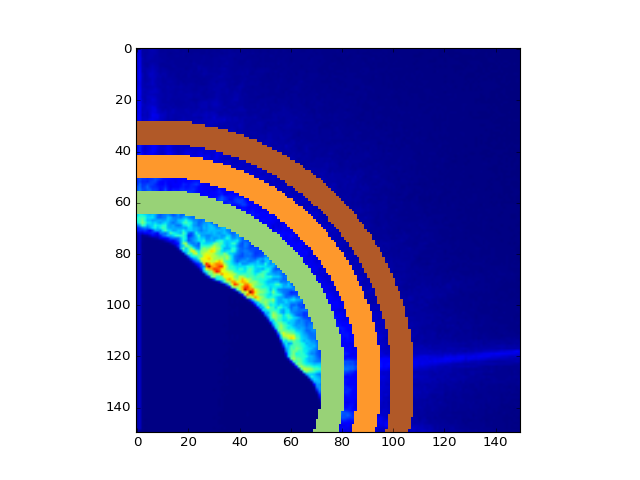

In [58]:
fig, ax = plt.subplots()
ax.imshow(np.sum(real_data, axis=0) / len(real_data))
show_label_array(ax, labeled_roi_array)

### Use the class-based partial data correlator in scikit-beam

<IPython.core.display.Javascript object>


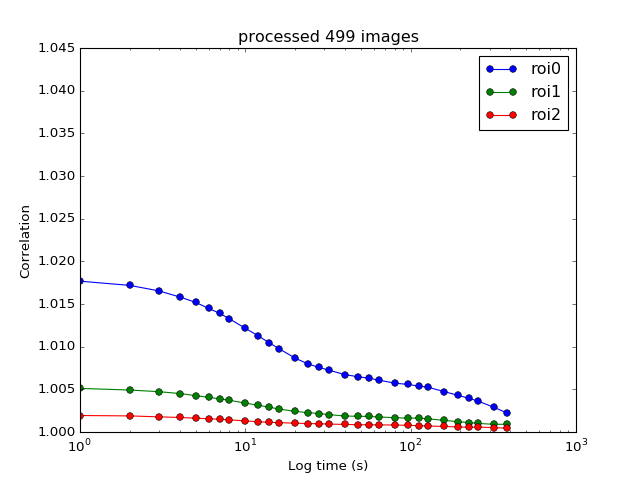

In [60]:
fig2, ax2 = plt.subplots()
ax2.set_xscale('log')

In [61]:
mt = MultiTauCorrelation(real_data_levels, real_data_bufs, labeled_roi_array)

#### Show incremental updates with the class-based correlator

In [66]:
mt.reset()
for im in real_data:
    mt.process(im)
    # update image every 10th image for performance
    if mt._processed % 10 == 0:
        update_plot(ax2, mt.g2, mt.lag_steps, mt._processed)
else:
    # do a final update to get the last bit
    update_plot(ax2, mt.g2, mt.lag_steps, mt._processed)

#### Show incremental updates with the generator-based correlator

In [5]:
from skxray.core import correlation as corr

<IPython.core.display.Javascript object>


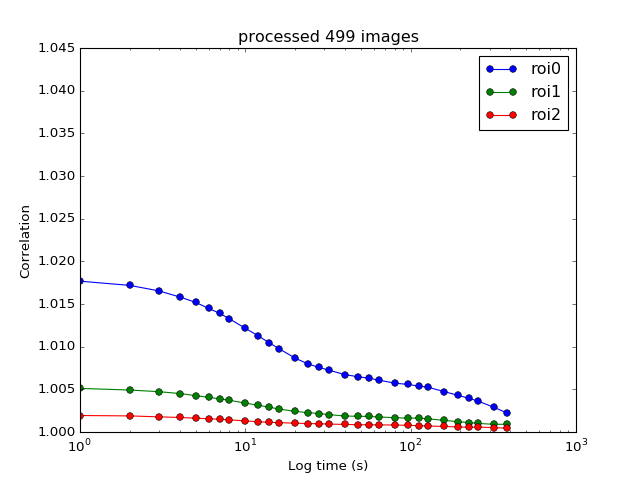

In [6]:
fig3, ax3 = plt.subplots()
ax3.set_xscale('log')

In [78]:
gen = corr.multi_tau_auto_corr(
    real_data_levels, real_data_bufs, labeled_roi_array, (im for im in real_data))

In [79]:
for num, res in enumerate(gen):
    # update every 10th image for performance if the generator yields an 'intermediate_data' 
    # namedtuple
    if num % 10 == 0 and type(res).__name__ == 'intermediate_data':
        
        update_plot(ax3, res.g2, res.lag_steps, num)
else:
    # update with the final "results" value which is a tuple of (g2, lag_steps)
    update_plot(ax3, res[0], res[1], num-1)

### Time the two implementations. They are of equivalent performance

In [80]:
%%timeit -n5
pass
mt.reset()
for im in real_data:
    mt.process(im)
res = mt.g2, mt._lag_steps

5 loops, best of 3: 456 ms per loop


In [81]:
%%timeit -n5
gen = corr.multi_tau_auto_corr(
    real_data_levels, real_data_bufs, labeled_roi_array, (im for im in real_data))
res = list(gen)[-1]

5 loops, best of 3: 452 ms per loop


### Demonstrate that the generator/class implementation produce the same results

In [82]:
mt.reset()
for im in real_data:
    mt.process(im)
    
gen = corr.multi_tau_auto_corr(
    real_data_levels, real_data_bufs, labeled_roi_array, (im for im in real_data))
res = list(gen)[-1]

assert np.all(mt.g2 == res[0])